In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Utilities

In [4]:
from typing import Tuple

def is_power_of_two(n: int) -> bool:
    """
    Check if a given number is a power of two.
    """
    return (n & (n-1) == 0) and n != 0


def power_of_two(n: int) -> Tuple[int, int]:
    """
    Given a number, returns it's previous 
    and next of keen which are powers of two.
    """
    if is_power_of_two(n):
        return n, n
    count = 0    
    while n != 0:
        n >>= 1
        count += 1
    prev = 1 << (count-1)
    next = 1 << count
    return prev, next

# Loading MNIST dataset

In [5]:
from typing import Optional

def load_mnist(data_path: str,
               downscale: Optional[bool] = True) -> np.ndarray:
    num_labels = 10
    img_size = 28

    # data files
    train_data_path = os.path.join(data_path, 'mnist_train.csv')
    test_data_path = os.path.join(data_path, 'mnist_test.csv')

    # loading data
    train_data = np.loadtxt(train_data_path, delimiter=',')
    test_data = np.loadtxt(test_data_path, delimiter=',')

    # scaling to [0.01, 0.99]; we want to avoid zeros and ones
    frac = 0.99 / 255

    # extracting data and labels
    train_images = np.asfarray(train_data[:, 1:]) * frac + 0.01
    train_labels = np.asfarray(train_data[:, :1])

    test_images = np.asfarray(test_data[:, 1:]) * frac + 0.01
    test_labels = np.asfarray(test_data[:, :1])

    # transform labels into one hot representation
    lr = np.arange(num_labels)
    train_labels_one_hot = (lr==train_labels).astype(float)
    test_labels_one_hot = (lr==test_labels).astype(float)

    # we don't want zeroes and ones in the labels either
    train_labels_one_hot[train_labels_one_hot==0] = 0.01
    train_labels_one_hot[train_labels_one_hot==1] = 0.99
    test_labels_one_hot[test_labels_one_hot==0] = 0.01
    test_labels_one_hot[test_labels_one_hot==1] = 0.99

    if downscale:
        downscale_img = lambda img: img.reshape(28, 28)[::2,::2].reshape(-1,1)
        train_images = np.apply_along_axis(downscale_img, 1, train_images)
        test_images = np.apply_along_axis(downscale_img, 1, test_images)

    return {
        'train': {
            'images': train_images,
            'labels': train_labels_one_hot
        },
        'test': {
            'images': test_images,
            'labels': test_labels_one_hot
        }
    }

In [6]:
downscale = True
image_size = 28*28

if downscale:
    image_size = 14*14

data = load_mnist('../data/mnist', downscale)

Checking if data was loaded and scaled properly by plotting random digits...

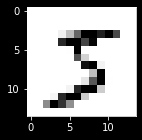

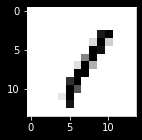

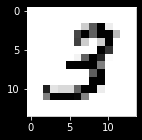

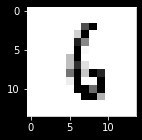

In [7]:
def show_digit(image_vec: np.ndarray, size: Optional[int]=None) -> None:
    if size is None:
        # assuming the image is square
        size = np.sqrt(data['train']['images'][0].size).astype(int)
    plt.rcParams["figure.figsize"] = (2,2)
    plt.imshow(image_vec.reshape(size, size), cmap="Greys")
    plt.show()

digits_idx = (0,23,157,996)    # plot random images
# plt.subplots(nrows=1, ncols=len(digits_idx))
for j in digits_idx:
    show_digit(data['train']['images'][j])

# Feature map

The feature map $\Phi(\bf x)$ maps inpunt data vector $\bf x$ from a space of dimension $N$ to a space of dimension $d^N$, i.e. each component of the input vector $x_j$ is mapped into a $d$-dimensional vector. See Eq. 8 in text.

The tensor $\Phi^{s_1 s_2 \cdots s_N}$ is the tensor productof the local feature maps $\Phi^{s_j}(x_j)$ applied to each input $x_j$ along the indices $s_j = 1,2,\cdots,N$. The local feature map is required to have unit norm analogous to the wave function norm, otherwise the tensor networks are not guaranteed to be numerically stable.



In [8]:
from typing import Callable, Iterable, Optional

FMap = Callable[np.ndarray, np.ndarray] # type alias

def feature_map(xs: Iterable, 
                f: FMap,
                *fs: Iterable[FMap],
                acc: Optional[np.ndarray]=None) -> np.ndarray:
    """
    Feature mapping. 
    """
    vf = np.vectorize(f)
    acc = vf(xs) if acc is None else np.r_[acc, vf(xs)]
    if fs:
        yield from feature_map(xs, *fs, acc=acc)
    else:
        yield acc

Below is the vector of feature maps that are going to be applied to each value $x_j$. This might be an overkill for this particular set of feature maps, but we want to be agnostic to any feature maps set. Alternative fetaure definition used in other papers is porvided below.

In [9]:
features = [
    lambda _: 1,
    lambda x: x,
    lambda x: x**2,

]

# features = [
#   lambda x: np.cos( (np.pi/2) * x ),
#   lambda x: np.sin( (np.pi/2) * x ),
# ]

N = len(data['train']['images'])    # Number of training samples

feature_extractor_iter = feature_map(
    data['train']['images'], 
    *features
)

Phi = np.vstack(
    list(feature_extractor_iter))\
    .reshape(len(features), N, image_size)\
    .transpose(0,2,1)


In [10]:
Phi.shape

(3, 196, 60000)

Normalizing the features so we can trivially contract them

In [11]:
def normalize_along_axis(a: np.ndarray, 
                         ord: Optional[int]=2,
                         axis: Optional[int]=-1) -> np.ndarray:
    z = np.atleast_1d(np.linalg.norm(a, ord, axis))
    z[z==0] = 1
    return a / np.expand_dims(z, axis)

#Phi = normalize_along_axis(Phi, axis=0)

checking the normalization on a random sample of features and images

In [12]:
# sample_size = 10

# for i in range(sample_size):
#     m = np.random.choice(Phi.shape[1])
#     n = np.random.choice(Phi.shape[2])
#     assert np.allclose(Phi[:,m,n].T @ Phi[:,m,n], 1)

Checking if images are correctly processed (may not work for arbitrary feature)

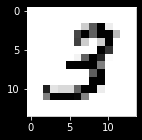

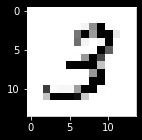

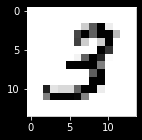

In [13]:
img = Phi[:,:,157]   # each image is a (1,x,x^2) represenattion
show_digit(img[1,:]) # image asfter the first feature map (x, i.e. same image) 
show_digit(img[2,:]) # same image asfter the second feature map (x^2)
show_digit(data['train']['images'][157])

# Computing the reduced covariance matrix and truncate

In [12]:
from typing import Iterable

def sliding_window(xs: Iterable, 
                   size: int, 
                   step: Optional[int]=1,
                   complement: Optional[bool]=False) -> Iterable:
    """
    Sliding window iterator

    Input:
    ------
    xs:         iterable
    size:       window size
    step:       step size
    complement: return a complement
    
    Output:
    -------
    Iterable
    """
    assert step > 0, "Parameter 'step' must be > 0"
    N = len(xs)
    i = 0
    while i + size <= N:
        mask = np.ones(N, dtype=bool)
        mask[i:i+size] = False
        if complement:
            yield xs[~mask].tolist(), xs[mask].tolist()
        else:
            yield xs[~mask].tolist()
        i += step

quickly checking

In [13]:
window_iterator = sliding_window(np.arange(10), size=2, step=2)
print(list(window_iterator))

[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]


In [14]:
from typing import Tuple

def ishermitian(a: np.ndarray, rtol=1e-06, atol=1e-08) -> bool:
    return np.allclose(a, a.conj().T, rtol=rtol, atol=atol)

def truncate_covariance(
    a: np.ndarray,
    eps: Optional[float]=1e-3
    ) -> Tuple[np.ndarray, np.ndarray]:

    """
    Approximate the input covariance matrix by a truncated version.
    Uses the eigendecomposition to diagonaize the input matrix
    and truncates the spectrum p that satisfies the condition
    sum(p)/trace(a) < eps.

    Input:
    ------
    a:      Matrix to be truncated
    eps:    The truncation error

    Output:
    -------
    p:      The remaining spectrum
    U:      The eigenvectors corresponding to p.
    D:      The index of the smallest non-negligible eigenalue.
    """
    assert ishermitian(a), 'Input matrix is not Hermitian'    
    # the eignevalue decomposition
    p, U = np.linalg.eigh(a)  # p are sorted in ascending order
    # checking the contribution of eignevalues and get the index D
    err = np.cumsum(p / np.trace(a))  # errors see Eq. (19) in text
    idx = np.min(np.where(err >= eps))  # non-negligible errros
    return p, U, idx

quickly checking

In [15]:
np.random.seed(111)
v = np.random.rand(30,10) + 1j*np.random.rand(30,10)
a = v @ v.conj().T  # covariance matrix

p,U,D = truncate_covariance(a)
assert np.allclose((U[:,D:] * p[D:]) @ U[:,D:].conj().T, a)

In [16]:
from typing import Optional

def build_tree(a: np.ndarray,
               eps: Optional[float]=1e-3,
               ) -> np.ndarray:
    
    # getting the shape of the input tensor
    u,v,w = a.shape

    # assert is_power_of_two(q), 'The number of features must be a power of 2'

    # stopping criterium
    if v == 2: 
        return acc

    rho = np.einsum('ilj,klj->iklj', a, a.conj())                            # computes all density matrices for each j

    isometries  = np.empty(shape=(u**2, u**2, 0), dtype=float)                     # stores the isoemtries
    indices = np.empty(shape=(v // 2, 0), dtype=int)                               # stores the trancation idices for each isometry

    iterator = sliding_window(np.arange(v), step=2, size=2)                  # geting the sliding window iterator
    for i,j in iterator:

        # Getting the left side normalizer
        if i == 0:
            left = np.ones(w)
        else:
            left = np.einsum('ikj,ikj->j', a[:,:i,:], a[:,:i,:].conj())      # contraction of all parts to the left of the pointer (i.e. l)

        # Getting the right side normalizer
        if j == v-1:
            right = np.ones(w)
        else:
            right = np.einsum('ikj,ikj->j', a[:,j+1:,:], a[:,j+1:,:].conj())  # contraction all parts to the right of the pointer (i.e. r+1)

        rho_ij = np.einsum('ikj,mnj->imknj', rho[:,:,i,:], rho[:,:,j,:])      # reduced density matrix for the window
        rho_ij = np.einsum('...j,...j,...j', left, rho_ij, right)             # scaled by left and right parts (aka reduced density matrix)

        # eigen decomposition
        _, U, idx = truncate_covariance(rho_ij.reshape(u**2,u**2), eps)

        isometries = np.append(isometries, U[:,:,np.newaxis], axis=2)
        indices = np.append(indices, idx)
        
    # get a uniform trancation index for ALL isometries (see Eq. 19)
    D = np.min(indices)

    return isometries[:,D:,:].reshape(u,u,-1,v//2)
    # TODO Ideally, the function need to be recursive, where each next layer is computed from the output of the previous layer. But, how to  do it?

In [17]:
layer = build_tree(Phi, eps=1e-3)

In [18]:
layer.shape

(3, 3, 9, 98)

In [20]:
layer.reshape(-1,98).shape

(81, 98)

# Sandbox below

# Brute force method (easy to understand)

In [3]:
np.random.seed(0)
Phi = np.random.rand(3, 196, 1000)

In [4]:
%%timeit

l,r = 8,9

u,v,w = Phi.shape

rho = np.zeros([u,u,u,u])
for j in range(w):
    left = np.einsum('ik,ik', Phi[:,:l,j], Phi[:,:l,j].conj())
    right = np.einsum('ik,ik', Phi[:,r+1:,j], Phi[:,r+1:,j].conj())

    # i   m
    # |   |
    # +---+
    # |   |
    # +---+
    # |   |
    # k   n

    for i in range(u):
        for k in range(u):
            for m in range(u):
                for n in range(u):
                    rho[i,k,m,n] += left * right * Phi[i,l,j] * Phi[m,l,j].conj() * Phi[k,r,j] * Phi[n,r,j].conj()
print(rho)

]
   [ 94098.94256293  94761.84139012 130483.43236083]]]


 [[[120171.55966581  84735.83235273  91501.60809887]
   [162293.30613319 114534.98145551 122146.31621996]
   [120489.68940122  87716.14802678  92859.37050605]]

  [[ 84735.83235273 113935.95891305  88232.47599647]
   [114534.98145551 151100.77270045 115336.86305176]
   [ 87716.14802678 118856.52207956  91209.43481937]]

  [[ 91501.60809887  88232.47599647 125696.07772977]
   [122146.31621996 115336.86305176 162427.99630931]
   [ 92859.37050605  91209.43481937 125430.47240046]]]


 [[[121479.06835179  88737.31563102  94098.94256293]
   [120489.68940122  87716.14802678  92859.37050605]
   [165582.01441452 122045.55316112 128079.21435365]]

  [[ 88737.31563102 121312.51854112  94761.84139012]
   [ 87716.14802678 118856.52207956  91209.43481937]
   [122045.55316112 163508.26747133 127112.61517384]]

  [[ 94098.94256293  94761.84139012 130483.43236083]
   [ 92859.37050605  91209.43481937 125430.47240046]
   [128079.21435365 127112.6

Same as above, but using vectorization

In [5]:
%%timeit
u,v,w = Phi.shape

l,r = 8,9

rho = np.einsum('ilj,klj->iklj', Phi, Phi.conj())                     # computes all density matrices for each j

left = np.einsum('ikj,ikj->j', Phi[:,:l,:], Phi[:,:l,:].conj())       # contraction of all parts to the left of the pointer (i.e. l)
right = np.einsum('ikj,ikj->j', Phi[:,r+1:,:], Phi[:,r+1:,:].conj())  # contraction all parts to the right of the pointer (i.e. r+1)

rho = np.einsum('ikj,mnj->imknj', rho[:,:,l,:], rho[:,:,r,:])         # reduced density matrix for the window

rho = np.einsum('...j,...j,...j', rho, left, right)                   # scaled by left and right

print(rho)


   [ 94098.94256293  94761.84139012 130483.43236083]]]


 [[[120171.55966581  84735.83235273  91501.60809887]
   [162293.30613319 114534.98145551 122146.31621996]
   [120489.68940122  87716.14802678  92859.37050605]]

  [[ 84735.83235273 113935.95891305  88232.47599647]
   [114534.98145551 151100.77270045 115336.86305176]
   [ 87716.14802678 118856.52207956  91209.43481937]]

  [[ 91501.60809887  88232.47599647 125696.07772977]
   [122146.31621996 115336.86305176 162427.99630931]
   [ 92859.37050605  91209.43481937 125430.47240046]]]


 [[[121479.06835179  88737.31563102  94098.94256293]
   [120489.68940122  87716.14802678  92859.37050605]
   [165582.01441452 122045.55316112 128079.21435365]]

  [[ 88737.31563102 121312.51854112  94761.84139012]
   [ 87716.14802678 118856.52207956  91209.43481937]
   [122045.55316112 163508.26747133 127112.61517384]]

  [[ 94098.94256293  94761.84139012 130483.43236083]
   [ 92859.37050605  91209.43481937 125430.47240046]
   [128079.21435365 127112.61

In [28]:
np.allclose(rho_slow, rho_lr)

True

In [35]:
def density(psi: np.ndarray) -> np.ndarray:
    """
    Create a density matrix from the state vector
    """
    return np.outer(psi, psi.conj().T)

In [37]:
u,v,w = Phi.shape

rho_2 = np.zeros([u,u,u,u])

left = np.einsum('ikj,ikj->j', Phi[:,:l,:], Phi[:,:l,:].conj())       # computes all parts to the left of the pointer (i.e. l)
right = np.einsum('ikj,ikj->j', Phi[:,r+1:,:], Phi[:,r+1:,:].conj())  # computes all parts to the right of the pointer (i.e. r+1)
rhos = np.einsum('ij,kj->ikj', Phi[:,l,:], Phi[:,l,:].conj())         # computes all density matrices for each j

for j in range(N):
    rho_j = np.einsum('ik,jl', density(Phi[:,l,j]), density(Phi[:,r,j]))
    rho_2 += left[j] * rho_j * right[j]



In [38]:
np.allclose(rho_slow, rho_2)

True

In [41]:
rho_2

array([[[[ 9968072.00800279,  7490889.83077619,  7480118.46071949],
         [ 7454956.65581029,  5589505.28092995,  5589053.45250698],
         [ 7450474.52478885,  5604036.01774869,  5609747.73507987]],

        [[ 7490889.83077619, 10048689.68436029,  7527217.13686993],
         [ 5589505.28092995,  7482860.94402133,  5600812.2962    ],
         [ 5604036.01774869,  7513750.38299611,  5640723.68925542]],

        [[ 7480118.46071949,  7527217.13686993,  9983935.42066202],
         [ 5589053.45250698,  5600812.2962    ,  7452723.6725855 ],
         [ 5609747.73507987,  5640723.68925542,  7483622.40060565]]],


       [[[ 7454956.65581029,  5589505.28092995,  5589053.45250698],
         [ 9942178.25034939,  7450451.46900852,  7449120.79489168],
         [ 7465780.71116004,  5610012.85749323,  5603134.34704745]],

        [[ 5589505.28092995,  7482860.94402133,  5600812.2962    ],
         [ 7450451.46900852,  9952975.56399989,  7440928.47243111],
         [ 5610012.85749323,  7477776.

In [273]:
l,h = win

# fully contruct the tensor Phi to the left and right of the window
left = np.einsum('ijk,ijk', Phi[:,:l,:], Phi[:,:l,:].conj())
right = np.einsum('ijk,ijk', Phi[:,h+1:,:], Phi[:,h+1:,:].conj())

Phi[:,:l,:].shape, Phi[:,h+1:,:].shape, left, right

((3, 8, 60000), (3, 186, 60000), 480049.502372654, 13615338.06618404)

In [274]:
# contracting the samples
rho = np.einsum('ijk,pqk->ijpq', Phi[:,l:h+1,:], Phi[:,l:h+1,:].conj())
# m,n,_,_ = 
rho.shape

(3, 2, 3, 2)

In [272]:
Phi[:,l:h+1,:].shape

(3, 9, 60000)

In [165]:
rho += left   # adding left side
rho += right  # adding right side
rho /= N      # normalizing to get the covariance

In [166]:
p,U = truncate_covariance(rho.reshape(m*n,-1))  # truncating the cobvariance

In [167]:
U = U.reshape(m,n,-1)  # reshaping back
U.shape

(3, 2, 1)

In [261]:
p

array([1409.5622609])

In [170]:
U

array([[[0.4082483 ],
        [0.4082483 ]],

       [[0.40824829],
        [0.40824829]],

       [[0.40824829],
        [0.40824829]]])